In [0]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import PIL.ImageOps    
from PIL import Image
import numpy as np
import itertools
import math
import sys
import os
from google.colab import drive
from scipy.spatial.distance import squareform

In [0]:
class Config():
    colors = ['aquamarine', 'bisque', 'blanchedalmond', 'blueviolet', 'brown',
              'burlywood', 'cadetblue', 'chartreuse','chocolate', 'coral',
              'cornflowerblue', 'cornsilk', 'crimson', 'darkblue', 'darkcyan',
              'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki',
              'darkmagenta', 'darkolivegreen', 'darkorange', 'darkslateblue',
              'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
              'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet',
              'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue',
              'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro',
              'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow',
              'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory']

In [3]:
savedir = ""
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    savedir = "/content/gdrive/My Drive/Mycode/"
    try:
        os.mkdir(savedir)
    except FileExistsError:
        print("Directory \"%s\" already exists" % (savedir))

print("Content of {}:".format(savedir))
os.listdir(savedir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Content of /content/gdrive/My Drive/Mycode/:


[]

In [0]:
simfilename = savedir + 'data.tsv'
labelfilename = savedir + 'labels.csv' # We will write the labels from dissim.tsv to here

X = np.genfromtxt(simfilename, delimiter='\t', encoding='utf8', dtype=None)

labels = []
for label in [x[0] for x in X]:
    if label in labels:
        continue
    labels.append(label)
for label in [x[1] for x in X]:
    if label in labels:
        continue
    labels.append(label)

adjmtx = np.zeros((len(labels), len(labels)))
for (s0, s1, w) in X:
    adjmtx[labels.index(s0), labels.index(s1)] = adjmtx[labels.index(s1), labels.index(s0)] = w

In [0]:
# Creates a NetworkX graph object
def make_graph(sim, labels=None):
    G = nx.Graph()
    for (i, j) in [(i, j) for i in range(sim.shape[0]) for j in range(sim.shape[1]) if i != j and sim[i,j] != 0]:
        if labels == None:
            G.add_edge(i, j, weight=sim[i,j])
        else:
            G.add_edge(labels[i], labels[j], weight=sim[i,j])
    return G

# Generate and download edges for Gephi  
def export_edge_list(sim, labels=None, filename="edges.csv", delim=",", header=True):
    f = open(savedir + filename, 'w')
    if header:
        f.write("Source,Target\n")
    loc = np.where(sim > 0)
    for (i, j) in [(i, j) for (i, j) in zip(loc[0], loc[1]) if i < j]:
        if labels == None:
            f.write(str(i) + delim + str(j) + "\n")
        else:
            f.write("\"" + labels[i] + "\"" + delim + "\"" + labels[j] + "\"\n")                          
    f.close()

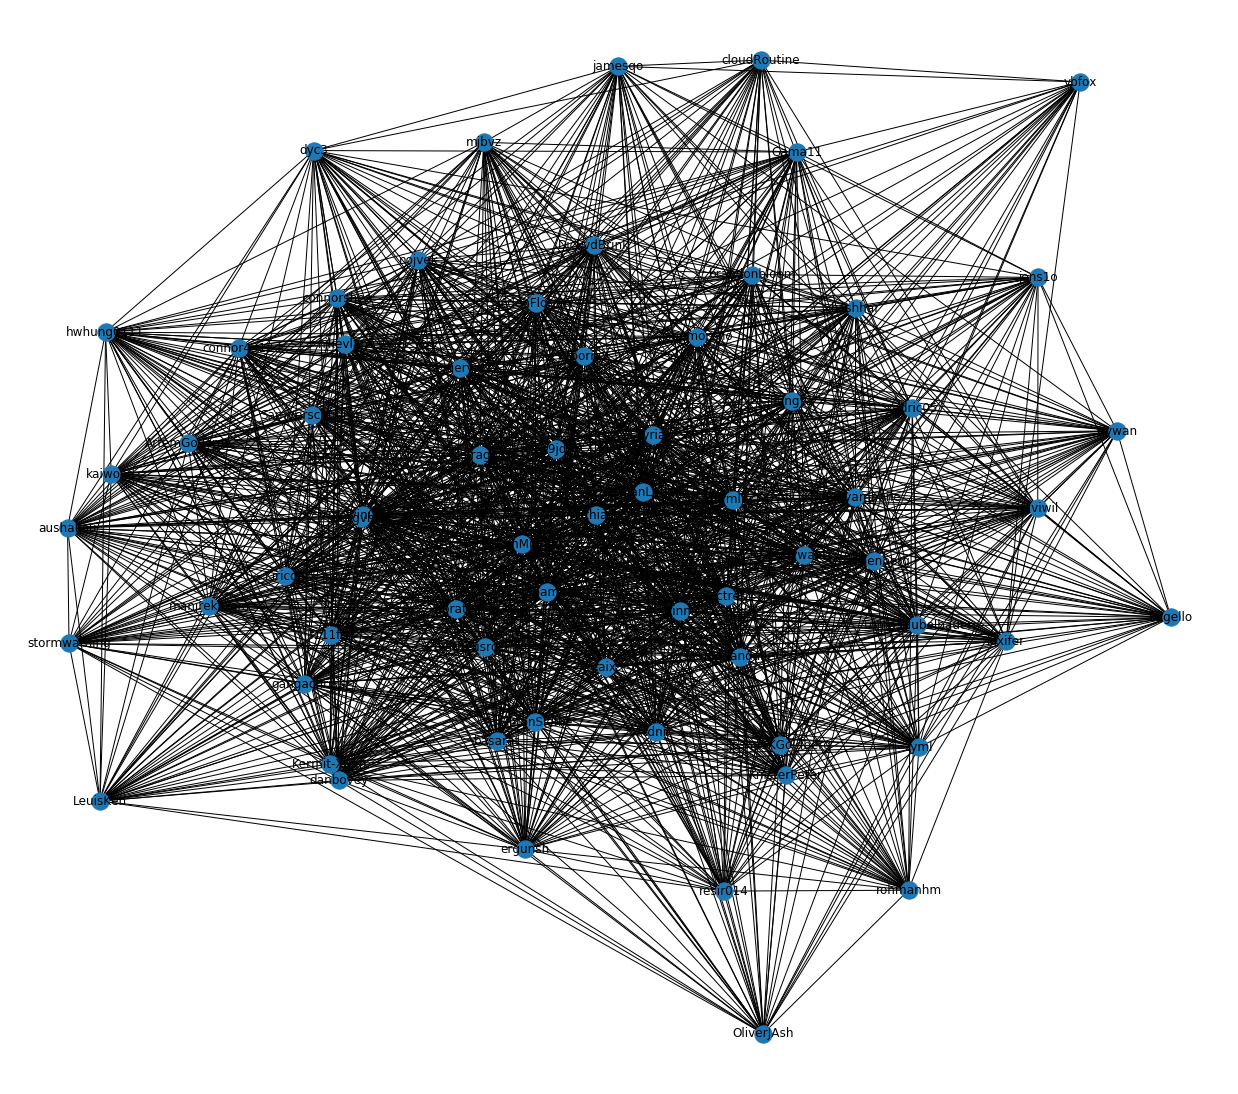

In [12]:
# Construct a networkx graph from the adjacency matrix
# (Singleton nodes are excluded from the graph)

G = make_graph(adjmtx, labels=labels)
plt.figure(figsize=(17, 15))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)

In [0]:
from networkx.algorithms.community.centrality import girvan_newman

comp = girvan_newman(G)

max_shown = 6
shown_count = 1
possibilities = []
for communities in itertools.islice(comp, max_shown):
    print("Possibility", shown_count, ": ", end='')
    print(communities)
    possibilities.append(communities)
    color_map = ["" for x in range(len(G))]
    color = 0
    for c in communities:
        indices = [i for i, x in enumerate(G.nodes) if x in c]
        for i in indices:
            color_map[i] = Config.colors[color]
        color += 1
    shown_count += 1
    plt.figure(figsize=(17, 15))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=color_map, with_labels=True)
    plt.show()

In [13]:
print(adjmtx)

[[ 0.  9. 10. ...  4.  5.  6.]
 [ 9.  0. 12. ...  7.  9.  5.]
 [10. 12.  0. ...  7.  5.  5.]
 ...
 [ 4.  7.  7. ...  0.  0.  8.]
 [ 5.  9.  5. ...  0.  0.  0.]
 [ 6.  5.  5. ...  8.  0.  0.]]


In [22]:
#Expand by taking the e^th power of the matrix.
def _expand(probabilityMat, power):
    expandMat = np.copy(probabilityMat)
    for i in range(power - 1):
        expandMat = np.dot(expandMat, probabilityMat)
    return expandMat

#Inflate by taking inflation of the resulting 
#matrix with parameter inflation. 
def _inflate(expandMat, inflation):
    powerMat = np.copy(expandMat)
    for i in range(inflation - 1):
        powerMat = powerMat * expandMat
    inflateColumnSum = np.sum(powerMat, axis = 0)
    inflateMat = powerMat / inflateColumnSum
    return inflateMat

def markovCluster(adjacencyMat, numIter, power = 2, inflation = 2):
    adj = np.copy(adjacencyMat)
    one_mat = np.eye(len(adj), dtype=float)
    adj = adj + one_mat
    columnSum = np.sum(adj, axis = 0)
    inflateMat = adj / columnSum
     
    for i in range(numIter):
        expand = _expand(inflateMat, power)
        inflateMat = _inflate(expand, inflation)
    return inflateMat

temp = markovCluster(adjmtx,10)
temp[temp < 1e-1] = 0
temp[temp > (1 - 1e-1)] = 1
for i in range(adjmtx.shape[0]):
    for j in range(adjmtx.shape[1]):
        if(temp[i, j] == 1):
            print(i, j)

4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
4 31
4 32
4 33
4 34
4 35
4 36
4 37
4 38
4 39
4 40
4 41
4 42
4 43
4 44
4 45
4 46
4 47
4 48
4 49
4 50
4 51
4 52
4 53
4 54
4 55
4 56
4 57
4 58
4 59
4 60
4 61
4 62
4 63
4 64
4 65
4 66


In [0]:
from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(dismat)
H = model.components_
# G = make_graph(adjmat, labels=labels)
# plt.figure(figsize=(17, 15))
# pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True)

